In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from  scipy.stats import norm
from  scipy.stats import binom
from scipy.stats import beta
from  scipy.stats import uniform
from scipy.stats import gaussian_kde

import pystan
from pystan.constants import MAX_UINT

import os

os.environ["CC"] = "g++-10"
os.environ["CXX"] = "g++-10"

%run ./tools.py

# Exercise A

The goal of this exercise is to implement the Metropolis-Hastings method as seen in Lesson 5. Consider a variable y_i representing the number of success of an experiment i repeated n times. Now consider a vector Y containing the number of success of N independent experiments y_i. We assume that each experiment_i share a common probability of success $\theta = 0.3$. Therefore we can generate the following data:

In [2]:
N = 100
n = 100
theta = 0.3

Y = binom.rvs(n, theta, size=N)
    
print(Y[:10])

[28 30 26 33 36 32 31 30 35 31]


**1) We will assume a prior Beta distribution with parameters a=0.5 and b=0.5 for $\theta$. Write the data likelihood p(Y|$\theta$) and the posterior distribution p($\theta$ | Y).**

**2) Estimate the posterior distirbution p($\theta$|Y) using the Metropolis-Hastings algorithm.**

In [3]:
def proposal(prop_mu, prop_sigma):
    return scipy.stats.norm.rvs(loc = prop_mu, scale = prop_sigma, size = 1)

def log_likelihood(param):
    return np.sum([binom.logpmf(y_i,n,param) for y_i in Y])

def log_prior(param):
    return beta.logpdf(param, 0.5, 0.5)

def log_posterior(param):
    return log_likelihood(param) + log_prior(param)

**3) Plot the posterior probability density functions obtained with the MCMC approximation and the analytical solution.**

# Exercise B

This year a farmer ran an experiment  where he gave 10 cows medicine A and 10 medicine B and then measured whether they got sick (0) or not (1) during the summer season. Here is the resulting data:

In [4]:
cowA = np.array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
cowB = np.array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0])

**1) The farmer wants to know: How effective are the drugs? What is the evidence that medicine A is better or worse than medicine B ?**

The outcome for each cow taking medecine A can be modeled as a random variable following a Bernouilli distribution with parameter $\theta_1$. Similarly, the outcome for each cow taking medecine B can be modeled as a random variable following a Bernouilli distribution with parameter $\theta_2$. Let's assume a unifrom prior for both $\theta_1$ and $\theta_2$. Our goal here is to obtain a posterior distribution of these two parameters. In this exercise, we propose to do it through the HMC method using the Pystan package.

<hr>

In [106]:
model_code = """
data {
    int n1;
    int n2;
    int y1[n1];
    int y2[n2];
}
parameters {
    real<lower=0, upper=1> theta_1;
    real<lower=0, upper=1> theta_2;
}
model {
  theta_1 ~ uniform(0, 1);
  theta_2 ~ uniform(0, 1);
  y1 ~ bernoulli(theta_1);
  y2 ~ bernoulli(theta_2);
}
"""

In [107]:
data = {"n1": len(cowA), "n2":len(cowB),
        "y1":cowA, "y2":cowB}

In [108]:
model = pystan.StanModel(model_code = model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b215ac18649d41b01dbf61c40dfe08c2 NOW.


In [109]:
fit = model.sampling(data = data, seed = 1, iter=4000, chains=4)

In [110]:
fit

Inference for Stan model: anon_model_b215ac18649d41b01dbf61c40dfe08c2.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta_1   0.25  1.6e-3   0.12   0.06   0.16   0.24   0.33   0.52   5516    1.0
theta_2   0.58  1.7e-3   0.14   0.31   0.49   0.59   0.68   0.83   6347    1.0
lp__    -15.97    0.02   1.05  -18.9 -16.37 -15.65 -15.22 -14.93   3154    1.0

Samples were drawn using NUTS at Thu Dec  2 16:09:28 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [111]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

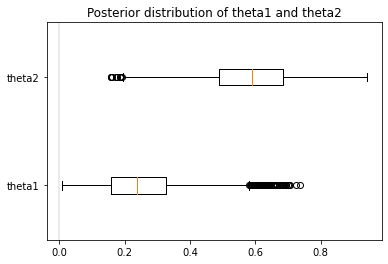

In [113]:
est_theta1 = fit.extract()["theta_1"]
est_theta2 = fit.extract()["theta_2"]

boxes = []
boxes.append(est_theta1)
boxes.append(est_theta2)

plt.boxplot(boxes, vert=0)
plt.yticks([1,2], ["theta1", "theta2"])
plt.axvline(x=0, color="black", alpha=0.1)
plt.title("Posterior distribution of theta1 and theta2")
plt.show()

[-0.04320568  0.34065995  0.6550048 ]


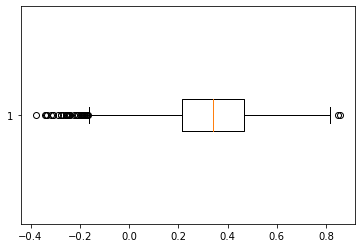

In [115]:
diff = est_theta2 - est_theta1
plt.boxplot(diff, vert=0)
print(np.quantile(diff, q=[0.025, 0.5, 0.975]))

<hr>

In [119]:
data = {"N": len(cowA), 
        "y_1":cowA, "y_2":cowB, 
        "lowbound_1":0, "upbound_1":1, 
        "lowbound_2":0, "upbound_2":1}

In [116]:
model_code = """
data {
    int<lower=1> N;
    int y_1[N];
    int y_2[N];
    int lowbound_1;
    int upbound_1;
    int lowbound_2;
    int upbound_2;
}
parameters {
    real<lower=0, upper=1> theta_1;
    real<lower=0, upper=1> theta_2;
}
model {
  theta_1 ~ uniform(lowbound_1, upbound_1);
  theta_2 ~ uniform(lowbound_2, upbound_2);
  y_1 ~ binomial(1, theta_1);
  y_2 ~ binomial(1, theta_2);
}
"""

In [117]:
model = pystan.StanModel(model_code = model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0377ab6da5039688b6040e0d789cd68a NOW.


In [120]:
fit = model.sampling(data = data, seed = 1, iter=4000, chains=4)

In [121]:
fit

Inference for Stan model: anon_model_0377ab6da5039688b6040e0d789cd68a.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta_1   0.25  1.5e-3   0.12   0.06   0.16   0.24   0.32   0.52   6541    1.0
theta_2   0.58  1.6e-3   0.14   0.31   0.49   0.58   0.68   0.83   6818    1.0
lp__    -15.94    0.02   1.04 -18.73 -16.33 -15.62 -15.19 -14.92   3014    1.0

Samples were drawn using NUTS at Thu Dec  2 16:22:58 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [122]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

**2)** Earlier this year the farmer  ran an experiment where he gave 10 cows a special diet that could increase the milk production. He recorded the number of liters of milk from these “diet” cows and from 15 “normal” cows during one month. This is the data:

\begin{align}
Y_1 &= (...)\\
Y_2 &= (...)\\
Y1 &\sim \mathcal{N}(\mu_1, \sigma_1)\text{  likelihood}\\
Y2 &\sim \mathcal{N}(\mu_2, \sigma_2)\text{  likelihood}\\
P(\mu_1) &= U[600, 200]\\
P(\sigma_1) &= U[0,100]\\
P(\mu_2) &= U[600,200]\\
P(\sigma_2) &= U[0, 100]\\
\end{align}

In [123]:
diet_milk = np.array([651., 679., 374., 601., 401., 609., 767., 709., 704., 679.])
normal_milk = np.array([798., 1139., 529., 609., 553., 743., 151., 544., 488., 555., 257., 692., 678., 675., 538.])

<span style="color:red">data = input</span>

<span style="color:red">parameters = output</span>

<span style="color:red">model = priors and likelihood</span>

In [159]:
model_code = """
data {
    int n1;
    int n2;
    vector[n1] y1;
    vector[n2] y2;
}
parameters {
    real mu1;
    real mu2;
    real<lower=1e-4> sigma1;
    real<lower=1e-4> sigma2;
}
model {
    mu1 ~ uniform(0, 2000);
    mu2 ~ uniform(0, 2000);
    sigma1 ~ uniform(0, 100);
    sigma2 ~ uniform(0, 100);
    y1 ~ normal(mu1, sigma1);
    y2 ~ normal(mu2, sigma2);
}
"""

In [160]:
data = {"n1":len(diet_milk),"n2":len(normal_milk),"y1":diet_milk, "y2":normal_milk}

In [161]:
model = pystan.StanModel(model_code = model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68ac7706fa4602f1b5a1a6c3c0405a7a NOW.


In [162]:
fit = model.sampling(data = data, seed = 1, iter=4000, chains=4)

In [163]:
fit

Inference for Stan model: anon_model_68ac7706fa4602f1b5a1a6c3c0405a7a.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu1    617.65    0.75  51.41 511.56 587.17 617.93 648.45 721.94   4699    1.0
mu2    596.53    0.82  66.18 465.28 553.75 596.67 638.22 729.26   6545    1.0
sigma1 153.79    0.83  47.11  92.65 121.41 143.96 175.13 273.27   3234    1.0
sigma2 249.17    0.68  53.18 169.71 211.76  241.3 277.39 377.23   6044    1.0
lp__   -133.4    0.03   1.58 -137.4 -134.2 -133.1 -132.3 -131.5   2679    1.0

Samples were drawn using NUTS at Thu Dec  2 17:02:53 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [164]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

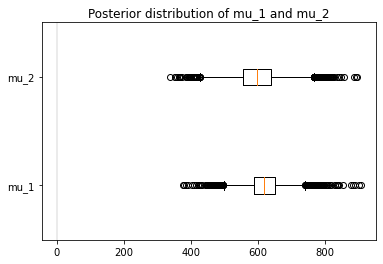

In [166]:
est_theta1 = fit.extract()["mu1"]
est_theta2 = fit.extract()["mu2"]

boxes = []
boxes.append(est_theta1)
boxes.append(est_theta2)

plt.boxplot(boxes, vert=0)
plt.yticks([1,2], ["mu_1", "mu_2"])
plt.axvline(x=0, color="black", alpha=0.1)
plt.title("Posterior distribution of mu_1 and mu_2")
plt.show()

[-185.26479295  -21.53188003  149.38431613]


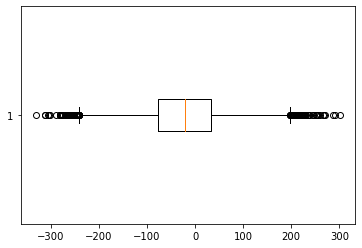

In [167]:
diff = est_theta2 - est_theta1
plt.boxplot(diff, vert=0)
print(np.quantile(diff, q=[0.025, 0.5, 0.975]))

**2a)** The farmer now wants to know: Was the diet any good, does it results in better milk production? 

The most common approach here would be to model the milk production of each cow as a normal distribution. For the cows following a diet, their milk production can be modeled as $y_i \sim \mathcal{N}(\mu_{diet}, \sigma^{2}_{diet})$, while for normal cows the milk production can be modeled as $y_i \sim \mathcal{N}(\mu_{normal}, \sigma^{2}_{normal})$.
We should also add priors for these four parameters. A lazy option here could be to assign them uniform priors.

**3)** The farmer also has chickens. He tries different diets on them too with the hope that they will produce more eggs. Below is the number of eggs produced in one week by chickens on a diet and chickens eating normal chicken food:

In [ ]:
diet_eggs = np.array([6, 4, 2, 3, 4, 3, 0, 4, 0, 6, 3])
normal_eggs =  np.array([4, 2, 1, 1, 2, 1, 2, 1, 3, 2, 1])

**3a)** The farmer now wants to know: Was the diet any good, does it result in the chickens producing more eggs ? 

In this case we want to model count data, therefore a reasonable choice to model the number of eggs produced by the chickens would be a Poisson distribution. This distribution has one parameter $\lambda$ which stands for the mean count. 

**4)** The farmer is now wondering whether the amount of time a cow spends outside in the sunshine affects how much milk she produces. To test this he makes a controlled experiment where he picks out 20 cows and assigns to each of them a number of hours she should spend outside each day. The experiment runs for a month and the farmer records the number of liters of milk each cow produces. The data is the following:

In [ ]:
milk = np.array([685, 691, 476, 1151, 879, 725, 1190, 1107, 809, 539, 298, 805, 820, 498, 1026, 1217, 1177, 684, 1061, 834])

hours = np.array([3, 7, 6, 10, 6, 5, 10, 11, 9, 3, 6, 6, 3, 5, 8, 11, 12, 9, 5, 5])


**4a)**  Using this data on hours of sunshine and resulting liters of milk the farmer wants to know: Does sunshine affect milk production positively or negatively?
